In [2]:
import numpy as np
import pandas as pd
import sklearn

from sklearn.datasets import fetch_20newsgroups as newsgroups

train = newsgroups(subset = 'train')
test = newsgroups(subset = 'test')

print(dir(train))

print(train.data[0])
print(train.target[0])
print(train.target_names[0])

#remove headers and footers so that our classifier will only fit to the body of the email
#remove quoted emails to reduce noise

train = newsgroups(subset = 'train', remove = ('headers', 'footers', 'quotes'))
test = newsgroups(subset = 'test', remove = ('headers', 'footers', 'quotes'))

['DESCR', 'data', 'filenames', 'target', 'target_names']
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





7
alt.atheism


In [3]:
print(train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


At the end of this notebook, I'll be running into major space-complexity issues, so I will not be able to work with the entire dataset.

In [4]:
TRAIN_LENGTH = 4000
TEST_LENGTH = 1000

X_train = [np.char.lower(email) for email in train.data[:TRAIN_LENGTH]] #all lower case
X_test = [np.char.lower(email) for email in test.data[:TEST_LENGTH]]

y_train = np.array(train.target[:TRAIN_LENGTH])
y_test = np.array(test.target[:TEST_LENGTH])

First, I preprocess the data. This consists of
1. Tokenzing: convert each email from a string to an array of strings.
['call me ishmael.'] becomes ['call', 'me', 'ishamel.']
2. Stopwords excision: stopwords are a collection of the most common English language stopwords such as 'for' and 'me'. They contribute very little semantic information; they're just noise. Tf-idfs actually have a built in mechanism to reduce the significance of the role played by stopwords (in the inverse document frequency portion of a tf-idf's construction), but I remove them anyways at the very least to reduce the amount of memory I'll need. 
3. Stemming: reduce all words to their root base. 'computer' and 'computed' 
4. Punctuation excision: similar logic to 2 above.

(Note, however, that stopwords and punctuation can play a function in detecting a given writer's style. Contrast the simple, blunt prose style of Hemingway with the long and meandering style of Faulkner. The latter will use significantly more punctuation and conjunctions.)

In [5]:
#tokenizing

X_train = [str(email).split() for email in X_train]
X_test = [str(email).split() for email in X_test]

#stopwords excision

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stopwords = list(stopwords.words('english'))

X_train = [[word for word in email if word not in stopwords] for email in X_train]
X_test = [[word for word in email if word not in stopwords] for email in X_test]

#stemming

from nltk.stem import PorterStemmer
ps = PorterStemmer()

X_train = [[ps.stem(word) for word in email] for email in X_train]
X_test = [[ps.stem(word) for word in email] for email in X_test]

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


Let's look at the data.

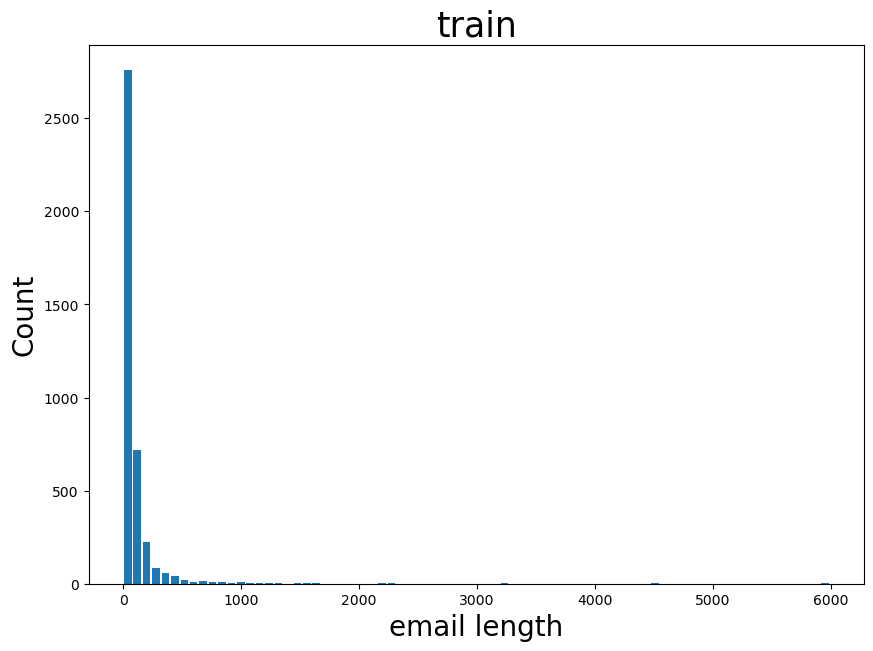

In [6]:
lengths_tr = [len(email) for email in X_train]
lengths_te = [len(email) for email in X_test]

from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.hist(lengths_tr, bins=75, rwidth = 0.8)
ax.set_xlabel('email length', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
ax.set_title('train', fontsize = 25)
fig.set_size_inches(10, 7)
plt.show()

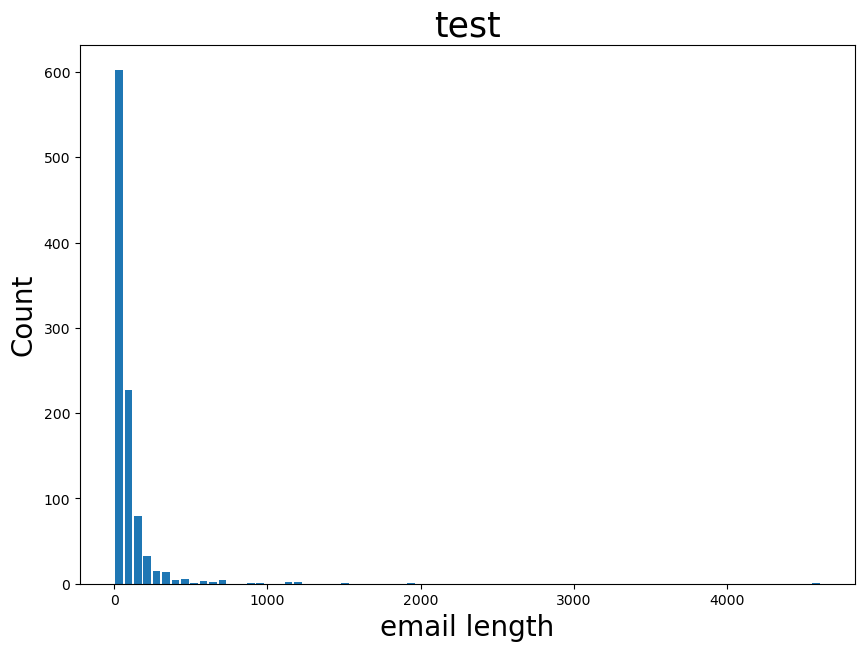

In [8]:
fig, ax = plt.subplots()

ax.hist(lengths_te, bins=75, rwidth = 0.8)
ax.set_xlabel('email length', fontsize = 20)
ax.set_ylabel('Count', fontsize = 20)
ax.set_title('test', fontsize = 25)
fig.set_size_inches(10, 7)
plt.show()

It makes sense to throw out the outliers. This will also help with performance.

In [9]:
X_train_trimmed = [email for email in X_train if 15 <= len(email) <= 100]
X_test_trimmed = [email for email in X_test if 15 <= len(email) <= 100]

indices_train = [ind for (ind, email) in enumerate(X_train) if 15 <= len(email) <= 100]
indices_test = [ind for (ind, email) in enumerate(X_test) if 15<= len(email) <= 100]

X_train = X_train_trimmed
X_test = X_test_trimmed

print(len(X_train), len(X_test))

2459 642


In [10]:
y_train = y_train[indices_train]
y_test = y_test[indices_test]

print(len(y_train), len(y_test))

2459 642


At this stage in this project I turn to manual construction of a tf-idf. In particular I will build a logarithmic tf-idf.

The code below could be improved a few ways, for example by using list comprehensions, but I'll leave it this way for readability.

In [11]:
lexicon  = []
for email in X_train:
    for word in email:
        if word not in lexicon:
            lexicon.append(word)

for email in X_test:
    for word in email:
        if word not in lexicon:
            lexicon.append(word)
         
        
import collections
from collections import Counter

count_train = Counter()
for email in X_train:
    unique_words = set(email)
    count_train.update(unique_words)

count_test = Counter()
for email in X_test:
    unique_words = set(email)
    count_test.update(unique_words)

The bottleneck of the algorithm below is in the calculation of the tf-idf vectors, which has a complexity of O(nm^2), where n is the number of emails and m is the size of the lexicon. This is because for each email, I need to calculate the tf-idf score for each word in the lexicon, which requires iterating over the entire email and lexicon.

In [12]:
import math
#the logarithmic definition of term frequency
def tf(term, email):
    return(math.log(1+(email.count(term))))

#modified definition of idf
def idf_train(term):
    return(math.log(len(X_train)/(1+count_train[term]))) 

#the only definition of term frequency-inverse domain frequency
def tfidf_train(term, email):
    return(tf(term, email)*idf_train(term))

#each email is mapped to a vector whose entries are tf-idf's of words in the lexicon
def vector_train(email):
    vector = []
    for term in lexicon:
        vector.append(tfidf_train(term, email))
    return(vector)

#Finally, we construct a matrix where each ith row is the tfidf vector for the ith email.
def tfidf_vectors_train(corpus):
    tfidf_vectors = []
    for i in range(len(corpus)):
        tfidf_vectors.append(vector_train(X_train[i]))
    return(tfidf_vectors)

In [13]:
def idf_test(term):
    return(math.log(len(X_test)/(1+count_test[term])))
           
def tfidf_test(term, email):
    return(tf(term, email)*idf_test(term))
           
def vector_test(email):
    vector = []
    for term in lexicon:
        vector.append(tfidf_test(term, email))
    return(vector)
           
def tfidf_vectors_test(corpus):
    tfidf_vectors = []
    for i in range(len(corpus)):
        tfidf_vectors.append(vector_test(X_test[i]))
    return(tfidf_vectors)

In [14]:
#this is the codeblock that I need to be careful with
X_train_vec = tfidf_vectors_train(X_train)
X_test_vec = tfidf_vectors_test(X_test)

#all told this codeblock is gonna cost about 3 GiB of memory

In [15]:
del X_train
del X_test

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_vec, y_train)

print("Score: %.3f"%clf.score(X_test_vec, y_test))

Score: 0.586
